# Using NSDF for anomalies detection in time series

<div>
    <center>
        <img src="files/docs/Logo.png" width="250"/>
    </center>
</div>

Colaborators: 

* Stanford Linear Accelerator Center (SLAC) 
* Super Cryogenic Dark Matter Search (SuperCDMS)
* Sudbury Neutrino Observatory Lab (SNOLAB)
* National Science Data Fabric (NSDF)

NSDF-Team:

* Heberth Martinez 
* Glenn Tarcea
* Giorgio Scorzelli
* Michela Taufer

## Preparing your Environment

The following cell prepares the environment by importing various crucial libraries for workflow execution. Please note that running this cell might take some time. Upon completion, a message will be displayed to notify you that the cell execution has finished.

In [10]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import warnings
import json
import boto3
from botocore.client import Config

warnings.filterwarnings("ignore")

print("You have successfully prepared your environment.")

You have successfully prepared your environment.


## Accessing Data from Seal Storage

The following cell establishes a connection with a private storage service such as Seal Storage and downloads previously generated data

In [11]:
print("Your download is starting...")

with open("./files/json/data.json", "r") as file:
    urls = json.load(file)

config = Config(signature_version="s3v4")
s3 = boto3.resource(
    "s3",
    endpoint_url="https://maritime.sealstorage.io/api/v0/s3",
    aws_access_key_id="any",
    aws_secret_access_key="any",
    config=config,
    verify=False,
)
bucket = s3.Bucket("utah")

bucket.download_file(urls[0].get("key"), "data.npz")


print("You have successfully downloaded the data from Seal Storage.")

Your download is starting...
You have successfully downloaded the data from Seal Storage.


* Load data using Numpy

In [12]:
# load data using numpy
npz = np.load("data.npz")
df = pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient="columns")
index = pd.date_range("1/1/2000", periods=df.shape[0], freq="1S")

# Creating train and test dataframes
df.index = index
new_df = df.iloc[: int(df.shape[0] * 0.9)]
test_df = df.iloc[int(df.shape[0] * 0.9) :]

# final data frame: frequency estimation
final_df = new_df.asfreq(pd.infer_freq(new_df.index))

print("You have successfully loaded the data.")
print("Number of values: ", df.shape[0])

You have successfully loaded the data.
Number of values:  1569218


* Plot raw data using Matplotlib 

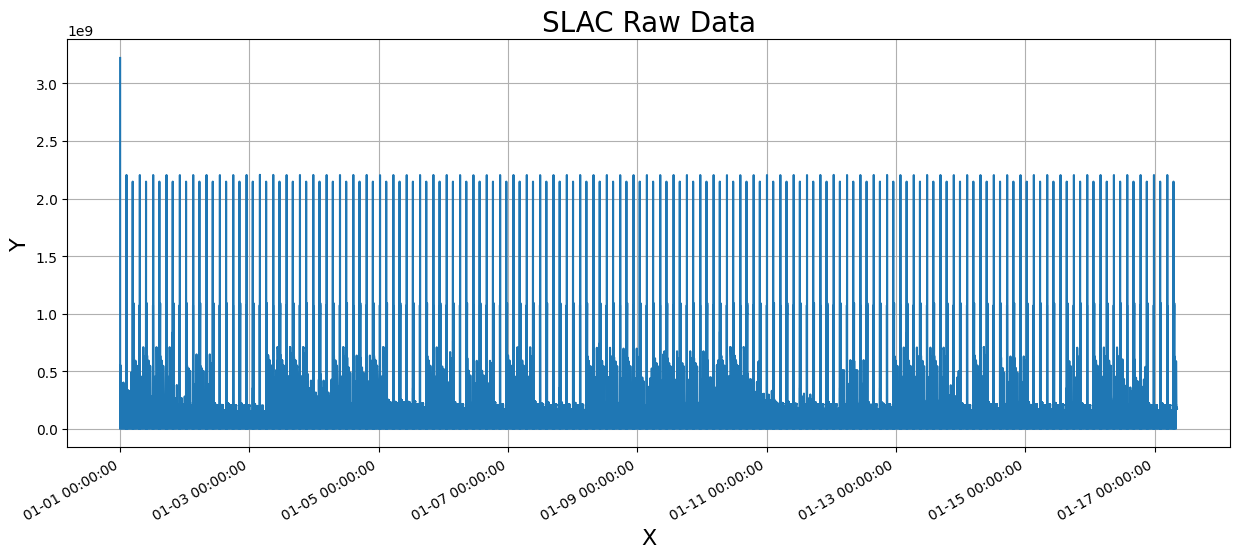

You have successfully plotted the data.


In [13]:
# plot train data
myFmt = mdates.DateFormatter("%m-%d %H:%M:%S")
plt.figure(figsize=(15, 6))
plt.plot(final_df)
plt.title("SLAC Raw Data", fontsize=20)
plt.ylabel("Y", fontsize=16)
plt.xlabel("X", fontsize=16)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()
print("You have successfully plotted the data.")

## Using Isolation Forest Algorithm for Anomalies Detection

Is an unsupervised machine learning algorithm for anomaly detection. As the name implies, Isolation Forest is an ensemble method (similar to random forest). In other words, it use the average of the predictions by several decision trees when assigning the final anomaly score to a given data point.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

* Importing important libraries

In [14]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

print("You have successfully imported the libries.")

You have successfully imported the libries.


* Set the contamination factor

In [15]:
# set contamination factor
outliers_fraction = float(0.01)

print("You have successfully set the contamination factor.")

You have successfully set the contamination factor.


* Create and train the model

In [16]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(final_df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

print("You have successfully created the model.")

You have successfully created the model.


* Make predictions and plot anomalies

In [17]:
# model prediction
np_scaled = scaler.fit_transform(test_df.values.reshape(-1, 1))
data_test = pd.DataFrame(np_scaled)
test_df["anomaly"] = model.predict(data_test)

print("You have successfully made the predictions.")

You have successfully made the predictions.


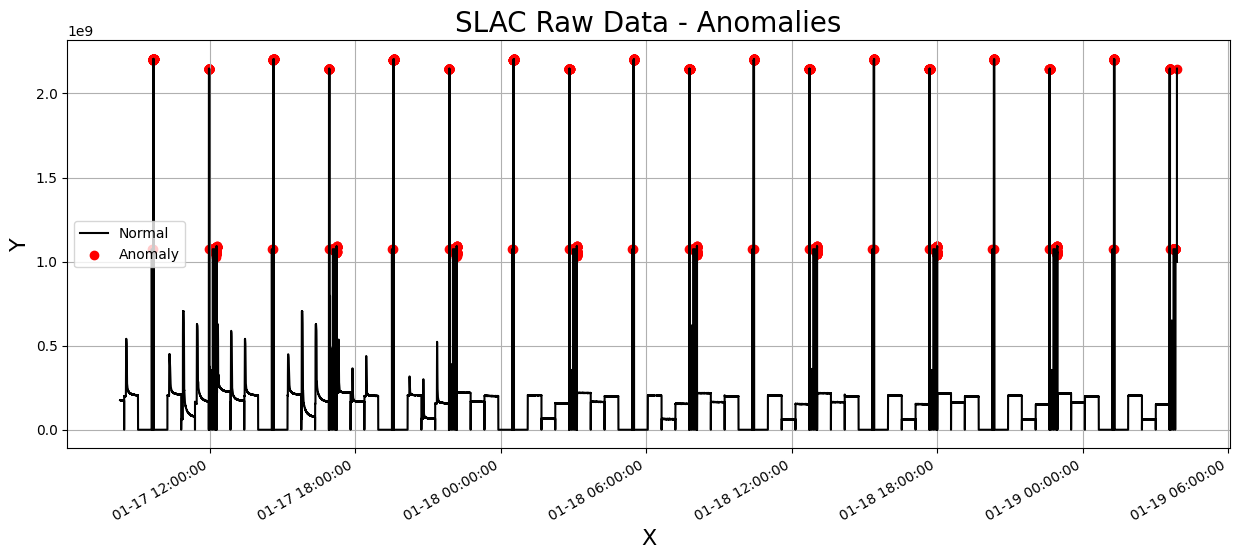

You have successfully plotted the anomalies.


In [18]:
# visualization
fig, ax = plt.subplots(figsize=(15, 6))
a = test_df.loc[test_df["anomaly"] == -1, ["data"]]  # anomalies
ax.plot(test_df.index, test_df["data"], color="black", label="Normal")
ax.scatter(a.index, a["data"], color="red", label="Anomaly")
plt.legend()
plt.grid()
myFmt = mdates.DateFormatter("%m-%d %H:%M:%S")
plt.title("SLAC Raw Data - Anomalies", fontsize=20)
plt.ylabel("Y", fontsize=16)
plt.xlabel("X", fontsize=16)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.show()

print("You have successfully plotted the anomalies.")